# Deepfake detection

## Install packages

In [3]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 6.7MB/s 


## Access to Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Import libraries

In [5]:
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import glob
import cv2
import os
from PIL import Image, ImageChops, ImageEnhance
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


import numpy as np
import pandas as pd

from keras.models import Sequential 
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,Activation,GlobalAveragePooling2D
from keras.layers import MaxPooling2D
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical
from keras import utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import LeakyReLU, ZeroPadding2D, BatchNormalization
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, auc, classification_report, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.regularizers import l2
from keras.models import model_from_json

from tqdm import tqdm # Progress bar and status logging
import shutil # high-level operations on files


%matplotlib inline

## Crop faces from images

### Example crop

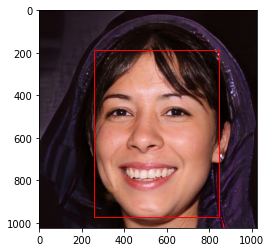

(258, 187, 846, 973)

In [8]:
# load image from folder
filename = 'gdrive/My Drive/data/train/fake/0.jpg'

def draw_image_with_boxes(filename, result_list):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # create the shape
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
    # show the plot
    pyplot.show()
    return(x,y,x+width,y+height)
    
detector = MTCNN()
# detect faces in the image
pixels = pyplot.imread(filename)
faces = detector.detect_faces(pixels)
# display faces on the original image
draw_image_with_boxes(filename, faces)

### All crop

#### Crop faces from train dataset

In [ ]:
## change the folder name accordingly for training and testing
path = 'gdrive/My Drive/data/train/'

folders = os.listdir(path)
#folders = folders[1:] ## [1:] to remove .ds_store folder if it is made automatically otherwise just use folder

detector= MTCNN()

## Iterate over the folder and detect and crop faces and save them in respective folder
for subs in folders:
    for files in os.listdir(path+subs):
        try:
            if 'fake' in path+subs+files and 'jpg' in path+subs+files:
                print(path+subs+'/'+files)
                pixels = pyplot.imread(path+subs+'/'+files)
                faces = detector.detect_faces(pixels)
                #coordinates = faces[0]['box']
                x1, y1, width, height = faces[0]['box']
                x2, y2 = x1 + width, y1 + height
                coordinates = [x1,y1,x2,y2]
                Image.fromarray(pixels).crop(coordinates).save('gdrive/My Drive/data/train_crop/fake/'+files)
            elif 'real' in path+subs+files and 'jpg' in path+subs+files:
                print(path+subs+'/'+files)
                pixels = pyplot.imread(path+subs+'/'+files)
                faces = detector.detect_faces(pixels)
                #coordinates = tuple(faces[0]['box'])
                x1, y1, width, height = faces[0]['box']
                x2, y2 = x1 + width, y1 + height
                coordinates = [x1,y1,x2,y2]
                Image.fromarray(pixels).crop(coordinates).save('gdrive/My Drive/data/train_crop/real/'+files)
        except (IndexError or SystemError):
            print('Face Not Found')

#### Crop faces from validation dataset

In [ ]:
## change the folder name accordingly for training and testing
path = 'gdrive/My Drive/data/validation/'

folders = os.listdir(path)
#folders = folders[1:] ## [1:] to remove .ds_store folder if it is made automatically otherwise just use folder

detector= MTCNN()

## Iterate over the folder and detect and crop faces and save them in respective folder
for subs in folders:
    for files in os.listdir(path+subs):
        try:
            if 'fake' in path+subs+files and 'jpg' in path+subs+files:
                print(path+subs+'/'+files)
                pixels = pyplot.imread(path+subs+'/'+files)
                faces = detector.detect_faces(pixels)
                #coordinates = faces[0]['box']
                x1, y1, width, height = faces[0]['box']
                x2, y2 = x1 + width, y1 + height
                coordinates = [x1,y1,x2,y2]
                Image.fromarray(pixels).crop(coordinates).save('gdrive/My Drive/data/validation_crop/fake/'+files)
            elif 'real' in path+subs+files and 'jpg' in path+subs+files:
                print(path+subs+'/'+files)
                pixels = pyplot.imread(path+subs+'/'+files)
                faces = detector.detect_faces(pixels)
                #coordinates = tuple(faces[0]['box'])
                x1, y1, width, height = faces[0]['box']
                x2, y2 = x1 + width, y1 + height
                coordinates = [x1,y1,x2,y2]
                Image.fromarray(pixels).crop(coordinates).save('gdrive/My Drive/data/validation_crop/real/'+files)
        except (IndexError or SystemError):
            print('Face Not Found')

## Load dataset

In [10]:
# Returns a np array of images and labels from path
# with resize and normalization 0.0-1.0

def get_images(path, img_shape=(64, 64)):
    y = []
    list = [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]
    print(list)
    image_collection = []
    for idx,folder in enumerate(list):
        label = idx
        sub_list = sorted(os.listdir(os.path.join(path,folder)))
        for i in tqdm(range(0, len(sub_list))):
            image_path = os.path.join(path, folder, sub_list[i])
            read_image = cv2.imread(image_path)
            image_resized = cv2.resize(read_image, img_shape, interpolation=cv2.INTER_AREA)
 
            image = np.float32(image_resized)
            image = cv2.normalize(image, None, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX) #, dtype=cv2.CV_32F)
            
            image_collection.append(image)
            y.append(label)
 
    y = np.array(y)
    y = utils.to_categorical(y,num_classes=len(list))
 
    return image_collection, y[:,0] 

In [11]:
TRAIN_DIR = 'gdrive/MyDrive/data/train_crop'
TEST_DIR = 'gdrive/MyDrive/data/validation_crop'

X_train,y_train = get_images(TRAIN_DIR,img_shape=(96,96))
X_test,y_test = get_images(TEST_DIR,img_shape=(96,96))
X_train = np.array(X_train)
X_test = np.array(X_test)

print('Training set', X_train.shape)
print('Test set', X_test.shape)

['fake', 'real']


100%|██████████| 700/700 [02:30<00:00,  4.64it/s]


['fake', 'real']


100%|██████████| 300/300 [01:03<00:00,  4.70it/s]

Training set (1400, 96, 96, 3)
Test set (600, 96, 96, 3)


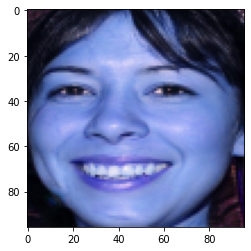

In [12]:
plt.imshow(X_train[0])

In [ ]:
X_train, y_train = shuffle(X_train, y_train)

## Model Selection and Parameterization

### CNN Grid Search hyperparameter

In [ ]:
N_EPOCHS = [50] #[25, 50]
OPTIMIZERS = ['adam'] #['adam', 'SGD']
DROPOUT_RATES =  [0.4] #[0.2, 0.4]
ACTIVATION = ['tanh'] #['relu', 'tanh']
NEURONS = [64] #[32,48,64]
REG = [0.0001]

In [ ]:
def build_classifier(optimizer, dropout, activation, neurons, reg):
    classifier = Sequential() 
    
    classifier.add(Conv2D(neurons, (3, 3), input_shape = (96, 96, 3), activation = activation, kernel_regularizer=l2(reg))) 
    classifier.add(MaxPooling2D(pool_size = (2, 2))) 
    classifier.add(Dropout(dropout))

    classifier.add(Conv2D(neurons, (3, 3), activation = activation, kernel_regularizer=l2(reg)))  
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(dropout))

    classifier.add(Conv2D(neurons, (3, 3), activation = activation, kernel_regularizer=l2(reg)))  
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(dropout))

    classifier.add(Conv2D(neurons, (3, 3), activation = activation, kernel_regularizer=l2(reg)))  
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(dropout))

    classifier.add(Flatten())
    classifier.add(Dense(units = neurons, activation = activation, kernel_regularizer=l2(reg)))
    #classifier.add(BatchNormalization())
    classifier.add(Dropout(dropout))
    classifier.add(Dense(units = 1, activation = 'sigmoid'))
    
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return classifier

classifier = KerasClassifier(build_fn = build_classifier, batch_size=32)

grid_parameters = {'epochs': N_EPOCHS,
                  'optimizer': OPTIMIZERS,
                  'dropout': DROPOUT_RATES,                  
                  'activation': ACTIVATION,
                  'neurons': NEURONS,
                  'reg': REG
                  }


grid_search = GridSearchCV( estimator = classifier,
                            param_grid = grid_parameters,
                            scoring = 'accuracy',
                            cv = 5,
                            n_jobs=-1
                          )


grid_search = grid_search.fit(X_train, y_train, verbose=0)

In [ ]:
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_
print('Best hyperparameters are: ')
print(best_parameters)
print('With accuracy: ')
print(best_accuracy)

Best hyperparameters are: 
{'activation': 'tanh', 'dropout': 0.4, 'epochs': 50, 'neurons': 64, 'optimizer': 'adam', 'reg': 0.0001}
With accuracy: 
0.6871428571428572


### Evaluate model

In [ ]:
yproba = grid_search.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  yproba)
auc = roc_auc_score(y_test, yproba)
print('AUC', auc)
print("Max Accuracy Registred: {} using {}".format(round(grid_search.best_score_,3), grid_search.best_params_))

AUC 0.8180444444444445
Max Accuracy Registred: 0.687 using {'activation': 'tanh', 'dropout': 0.4, 'epochs': 50, 'neurons': 64, 'optimizer': 'adam', 'reg': 0.0001}


In [ ]:
yproba = grid_search.predict_proba(X_train)[::,1]
fpr, tpr, _ = roc_curve(y_train,  yproba)
auc = roc_auc_score(y_train, yproba)
print('AUC', auc)
print("Max Accuracy Registred: {} using {}".format(round(grid_search.best_score_,3), grid_search.best_params_))

AUC 0.9814632653061225
Max Accuracy Registred: 0.687 using {'activation': 'tanh', 'dropout': 0.4, 'epochs': 50, 'neurons': 64, 'optimizer': 'adam', 'reg': 0.0001}


In [28]:
def model_evaluate(a_model, _x_test, _y_test, key=""):
    
    yproba = a_model.predict_proba(_x_test)[::,0]
    #yproba = yproba[:,1]
    #ypredicted = a_model.predict(_x_test)

    # extract metrics   tipically   y_true, y_pred
    fpr, tpr, _ = roc_curve(_y_test,  yproba)
    auc = roc_auc_score(_y_test, yproba)
    #conf_m = confusion_matrix(_y_test,ypredicted)


    result_table = pd.DataFrame(columns=['classifiers','auc', 'fpr', 'tpr', 'confusion_matrix'])
    result_table = result_table.append({'classifiers':a_model.__class__.__name__+"-"+key,
                                        'fpr':fpr,
                                        'tpr':tpr,
                                        'auc':auc,
                                        #'confusion_matrix': conf_m,
                                        }, ignore_index=True)
    return result_table

In [16]:
def plot_roc_insame(result_table):
    result_table.set_index('classifiers', inplace=True)
    
    fig = plt.figure(figsize=(8,6))
    
    for i in result_table.index:
        plt.plot(result_table.loc[i]['fpr'], 
                 result_table.loc[i]['tpr'], 
                 label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
        
    plt.plot([0,1], [0,1], color='black', linestyle='--')
    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=15)
    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)
    plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')
    plt.show()

In [17]:
def plot_precision_recall(a_model, _x_test, _y_test):

  yproba = a_model.predict_proba(_x_test) #[::,1]
  yproba = yproba[:,0]
  ypredicted = a_model.predict(_x_test)

  precision, recall, _ = precision_recall_curve(_y_test, yproba)

  pyplot.plot(recall, precision, marker='.', label='GridSearch')

  pyplot.xlabel('Recall')
  pyplot.ylabel('Precision')
  pyplot.legend()
  pyplot.show()

In [ ]:
predicted = grid_search.predict(X_test)

print('Confusion matrix for training set:')
print(confusion_matrix(y_train,grid_search.predict(X_train)))
print('\n')
print(classification_report(y_train,grid_search.predict(X_train)))

print('Confusion matrix  for test set:')
print(confusion_matrix(y_test,predicted))
print('\n')
print(classification_report(y_test,predicted))

### Save best model

In [ ]:
best_model = grid_search.best_estimator_.model
model_json = best_model.to_json()
with open("gdrive/My Drive/data/GridSearch/try_6.json", 'w') as json_file:
  json_file.write(model_json)
best_model.save_weights("gdrive/My Drive/data/GridSearch/try_6.h5")

### Load model from disk

In [36]:
# load json and create model
json_file = open("gdrive/My Drive/data/GridSearch/try_5.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("gdrive/My Drive/data/GridSearch/try_5.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy from test:")
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
Accuracy from test:
accuracy: 83.33%


In [34]:
results = model_evaluate(loaded_model, X_test, y_test)
results.head()

,classifiers,auc,fpr,tpr,confusion_matrix
0,Sequential-,0.818044,"[0.0, 0.0, 0.0, 0.0033333333333333335, 0.00333...","[0.0, 0.0033333333333333335, 0.016666666666666...",NaN


In [37]:
# For other models
results = results.append(model_evaluate(loaded_model, X_test, y_test))

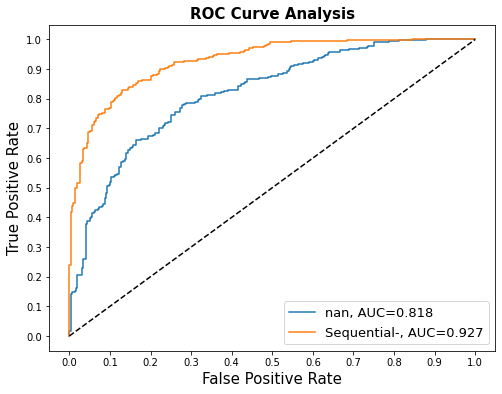

In [38]:
plot_roc_insame(results)

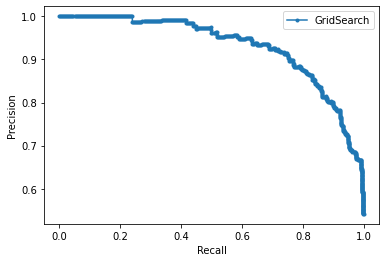

In [39]:
plot_precision_recall(loaded_model, X_test, y_test)

In [40]:
predicted_train = loaded_model.predict(X_train)

predicted_test = loaded_model.predict(X_test)

print('Confusion matrix for training set:')
print(confusion_matrix(y_train,predicted_train.round()))
print('\n')
print(classification_report(y_train,predicted_train.round()))

print('Confusion matrix  for test set:')
print(confusion_matrix(y_test,predicted_test.round()))
print('\n')
print(classification_report(y_test,predicted_test.round()))

Confusion matrix for training set:
[[465 235]
 [193 507]]


              precision    recall  f1-score   support

         0.0       0.71      0.66      0.68       700
         1.0       0.68      0.72      0.70       700

    accuracy                           0.69      1400
   macro avg       0.69      0.69      0.69      1400
weighted avg       0.69      0.69      0.69      1400

Confusion matrix  for test set:
[[234  66]
 [ 34 266]]


              precision    recall  f1-score   support

         0.0       0.87      0.78      0.82       300
         1.0       0.80      0.89      0.84       300

    accuracy                           0.83       600
   macro avg       0.84      0.83      0.83       600
weighted avg       0.84      0.83      0.83       600



### Check images corrected and missclassified

In [41]:
# Creating separate lists for correctly classified and misclassified images
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

In [42]:
# Generating predictions on validation set, storing in separate lists
pred = loaded_model.predict_proba(X_test)

for i in range(len(pred)):
    
    # Sorting into proper category
    if round(pred[i][0])==1 and y_test[i]==1:
        correct_real.append(X_test[i])
        correct_real_pred.append(pred[i][0])
    elif round(pred[i][0])==y_test[i] and y_test[i]==0:
        correct_deepfake.append(X_test[i])
        correct_deepfake_pred.append(pred[i][0])
    elif y_test[i]==1:
        misclassified_real.append(X_test[i])
        misclassified_real_pred.append(pred[i][0])
    else:
        misclassified_deepfake.append(X_test[i])
        misclassified_deepfake_pred.append(pred[i][0])   
    
    if i == len(pred)-1:
        print("All", len(pred), "predictions completed")

All 600 predictions completed


In [43]:
def plot(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;

View **real** faces **corrected** classified

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


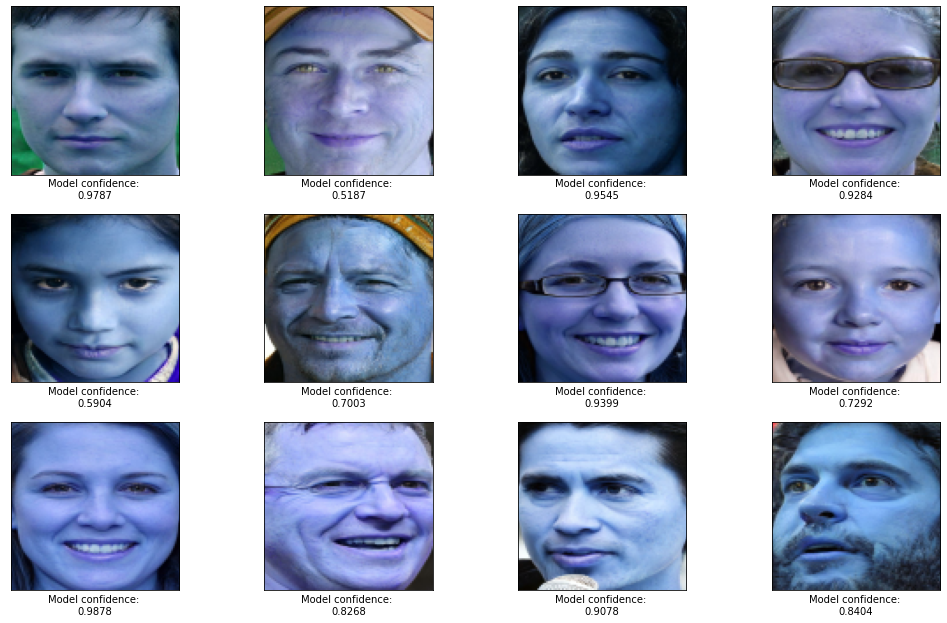

In [44]:
plot(correct_real, correct_real_pred)

View **real** faces **missclassified**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


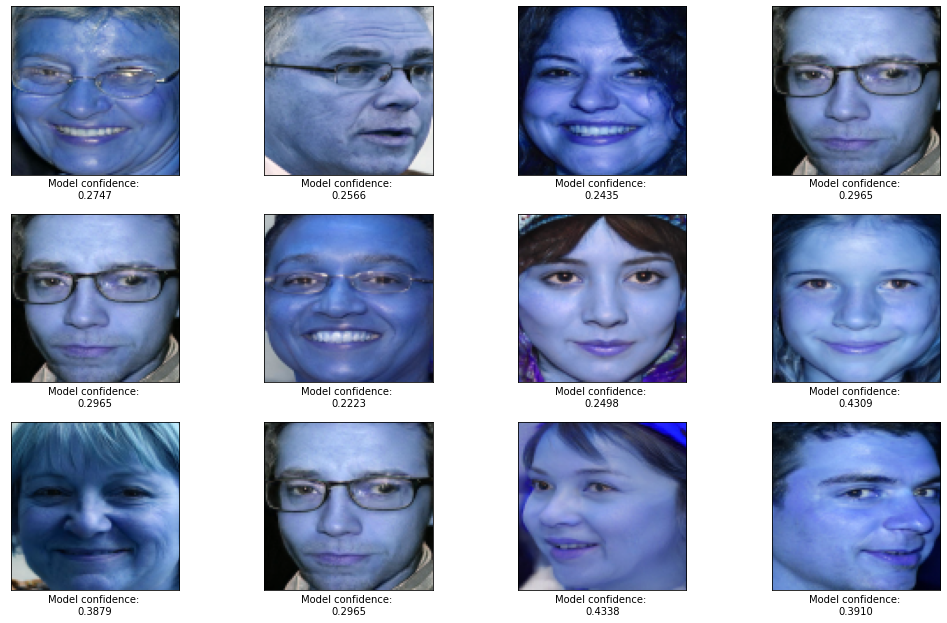

In [45]:
plot(misclassified_real, misclassified_real_pred)

View **fake** faces **correct** classified

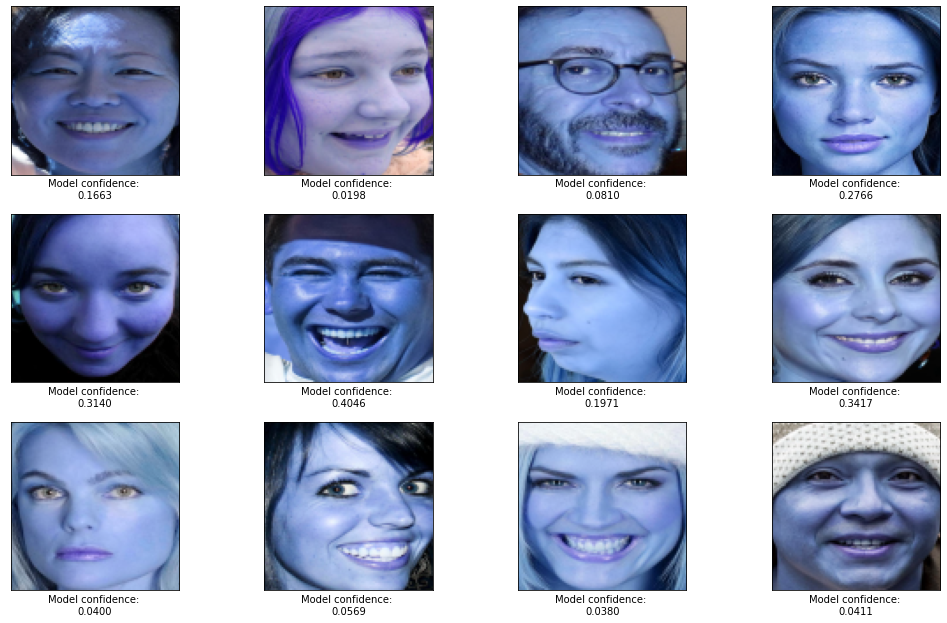

In [46]:
plot(correct_deepfake, correct_deepfake_pred)

View **fake** faces **missclassified**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


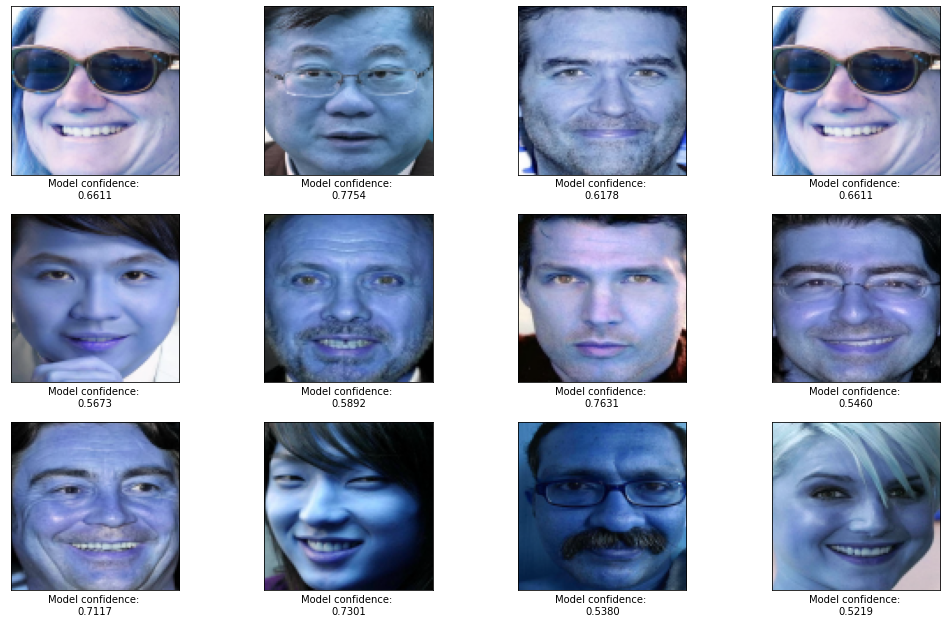

In [47]:
plot(misclassified_deepfake, misclassified_deepfake_pred)